<a href="https://colab.research.google.com/github/alecbidaran/ML-for-remote-sensing-Homeworks/blob/main/Preparing_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon,LinearRing
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image


%matplotlib inline

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
PROJECT_DIR = 'data/'

RASTER_PATH = os.path.join(PROJECT_DIR,"T34JEP_20170101T082332/T34JEP_20170101T082332_TCI.jp2")
TRAIN_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220805T124542Z-001/train/train.shp')
TEST_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'test-20220805T124609Z-001/test/test.shp')
TRAIN_POLYGONS_CONVERTED = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.geojson')
RASTER_MASK_PATH = os.path.join(PROJECT_DIR, 'mask.jp2')
FRAGMENT_STORAGE = os.path.join(PROJECT_DIR, 'split')
DROP_CSV_PATH = os.path.join(PROJECT_DIR, 'drop.csv')


In [ ]:
src=rasterio.open(RASTER_PATH,'r')
raster=src.read()
meta=src.meta

In [ ]:
eshaped_image=reshape_as_image(raster)

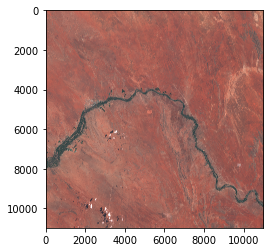

In [ ]:
plt.imshow(eshaped_image)

In [ ]:
train_df=gpd.read_file(TRAIN_POLYGONS_CONVERTED)

/home/ali/.local/lib/python3.8/site-packages/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/ali/.local/lib/python3.8/site-packages/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out


In [ ]:
train_df

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,"POLYGON ((613924.332 6793991.295, 614051.496 6..."
1,2,2.064410,3,6,"POLYGON ((614404.072 6794020.580, 614332.996 6..."
2,3,1.080300,3,8,"POLYGON ((614320.215 6793964.242, 614322.608 6..."
3,4,1.316190,3,8,"POLYGON ((614560.533 6794002.249, 614551.324 6..."
4,7,5.529220,3,8,"POLYGON ((614596.656 6794269.865, 614460.168 6..."
...,...,...,...,...,...
3563,3595,4.026750,6,None,"POLYGON ((544494.639 6857712.780, 544627.994 6..."
3564,3601,3.291510,7,None,"POLYGON ((541538.301 6854638.691, 541373.855 6..."
3565,3604,0.202729,3,None,"POLYGON ((614032.751 6794304.593, 614037.787 6..."
3566,3605,0.252428,3,None,"POLYGON ((613963.294 6794488.531, 614007.440 6..."


In [ ]:
transform=meta.get('transform')
~transform

Affine(0.1, 0.0, -49998.0,
       0.0, -0.1, 690004.0)

In [ ]:
def poly_to_edge(poly,transform):
    poly_pts=[]
    poy=cascaded_union(poly)
    for i in np.array(poy.exterior.coords):
        poly_pts.append(~transform*tuple(i))
    new_poly=LinearRing(poly_pts)
    return new_poly

<ipython-input-69-60f6b39bfbd2>:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poy=cascaded_union(poly)


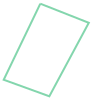

In [ ]:
edges=poly_to_edge(train_df["geometry"][1],transform)
edges

In [ ]:

# creating binary mask for field/not_filed segmentation.

poly_shp = []

for num, row in train_df.iterrows():
    # check geom type and apply function
    if row["geometry"].type=='MultiPolygon':
            for poly in row["geometry"]:
                poly=poly_to_edge(poly,transform)
                poly_shp.append(poly)
    else:
        converted_poly=poly_to_edge(row["geometry"],transform)
        poly_shp.append(converted_poly)

            
    # code here


# rasterize mask mask


bin_mask=rasterize(poly_shp,src.shape)
bin_mask[bin_mask>1]=1

<ipython-input-69-60f6b39bfbd2>:3: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poy=cascaded_union(poly)
<ipython-input-71-a29a02cd9bc1>:8: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in row["geometry"]:


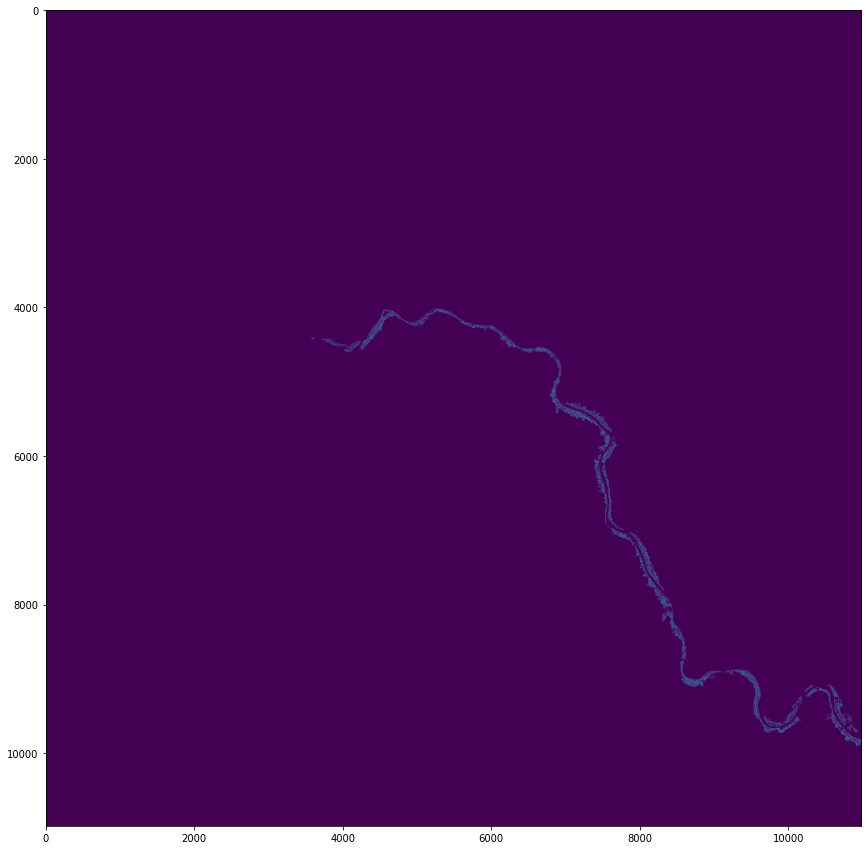

In [ ]:
# plotting the mask
plt.figure(figsize=(15,15))
plt.imshow(bin_mask)

In [ ]:
meta=src.meta

In [ ]:
meta.update({'count':1})
meta.update({'width': 10980})

In [ ]:
with rasterio.open(RASTER_MASK_PATH,'w',**meta) as dst:
    dst.write(bin_mask,1)

In [ ]:
# read from disk and plot
with rasterio.open(RASTER_MASK_PATH, "r") as src_mask:
    bin_mask = src_mask.read(1)

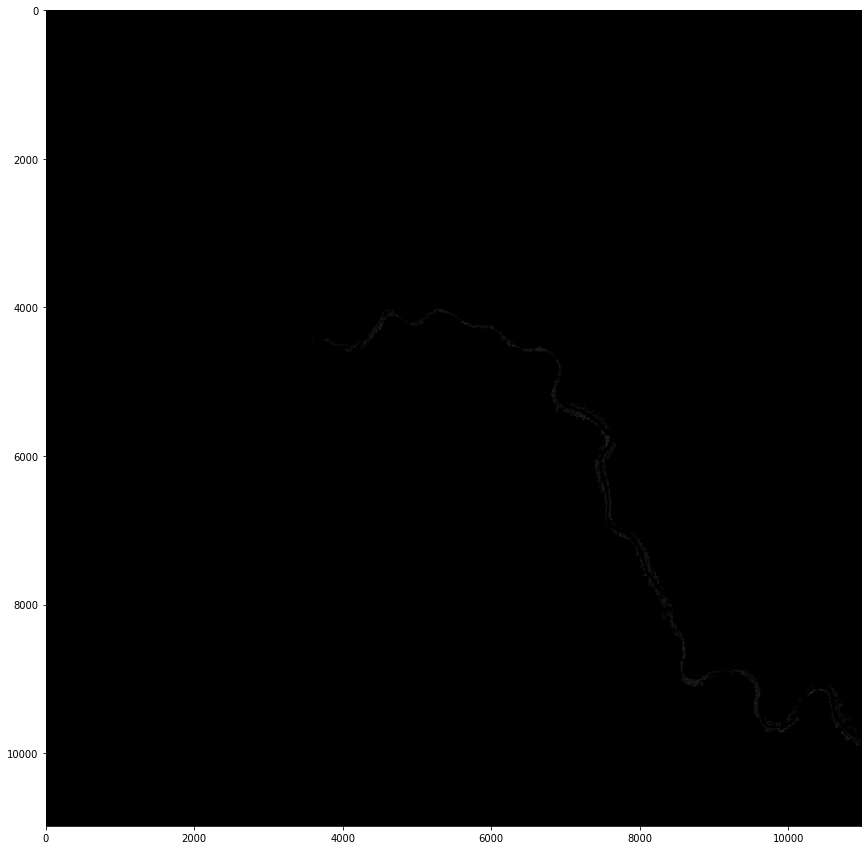

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(bin_mask,cmap='gray')

In [ ]:
def split_image(image_path,save_path,width,height):
    img_names=[]
    if not os.path.exists(save_path):
        os.mkdir(save_path,exists_ok=True)
        os.makedirs(f'{save_path}/images', exist_ok=True)
    os.makedirs(f'{save_path}/images', exist_ok=True)
    with rasterio.open(RASTER_PATH,'r') as src:
        for j in tqdm(range(0,src.height//height)):
            for i in range(0,src.width//width):
                raster_window=src.read(window=Window(i*width,j*height,width,height))
                raster_image=reshape_as_image(raster_window)[:,:,:3]
                if np.count_nonzero(raster_image)>raster_image.size*0.9:
                    filename_w_ext = os.path.basename(image_path)
                    filename, _ = os.path.splitext(filename_w_ext)
                    image_format = 'png'
                    piece_name = f'{filename}_{j}_{i}.{image_format}'
                    image_array=reshape_as_image(raster_window)
                    img_name = f'{save_path}/images/{piece_name}'
                    img_names.append(img_name)
                    cv2.imwrite(img_name,image_array)
    return img_names
                

In [ ]:
#split mask
def split_mask(image_path, save_path, width, height):
    
    mask_names = []
    drop_list = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/masks', exist_ok=True)
    with rasterio.open(image_path) as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(window=Window(i * width, j * height, width, height))
                image_array = reshape_as_image(raster_window)
                filename_w_ext = os.path.basename(image_path)
                filename, _ = os.path.splitext(filename_w_ext)
                piece_name = f'{filename}_{j}_{i}.png'

                image_array = reshape_as_image(raster_window)
                # add the code here to subsample 10% of images for train and add it to drop_list
                mask_name = f'{save_path}/masks/{piece_name}'
                mask_names.append(mask_name)
                if np.sum(image_array) == 0:
                    if np.random.random()<0.9:
                        drop_list.append(mask_name)
                image_array[image_array>1] = 1
                cv2.imwrite(mask_name, image_array)
                

    return mask_names, drop_list

In [ ]:
image_names = split_image(RASTER_PATH, FRAGMENT_STORAGE, 256, 256)

100%|██████████| 42/42 [07:10<00:00, 10.25s/it]


In [ ]:
mask_names, drop_list = split_mask(RASTER_MASK_PATH, FRAGMENT_STORAGE, 256, 256)

100%|██████████| 42/42 [00:07<00:00,  5.71it/s]


In [ ]:
drop_list_df = pd.DataFrame()
drop_list_df['images_to_drop'] = drop_list
drop_list_df.to_csv(DROP_CSV_PATH, index=False)

In [ ]:
drop_list=pd.read_csv(DROP_CSV_PATH)
drop_list=drop_list["images_to_drop"].str.split("/").str[-1].tolist()
drop_list

['mask_0_0.png',
 'mask_0_1.png',
 'mask_0_2.png',
 'mask_0_3.png',
 'mask_0_4.png',
 'mask_0_5.png',
 'mask_0_6.png',
 'mask_0_7.png',
 'mask_0_8.png',
 'mask_0_9.png',
 'mask_0_10.png',
 'mask_0_11.png',
 'mask_0_12.png',
 'mask_0_13.png',
 'mask_0_15.png',
 'mask_0_16.png',
 'mask_0_17.png',
 'mask_0_18.png',
 'mask_0_19.png',
 'mask_0_22.png',
 'mask_0_23.png',
 'mask_0_24.png',
 'mask_0_25.png',
 'mask_0_26.png',
 'mask_0_27.png',
 'mask_0_28.png',
 'mask_0_30.png',
 'mask_0_31.png',
 'mask_0_32.png',
 'mask_0_33.png',
 'mask_0_34.png',
 'mask_0_35.png',
 'mask_0_36.png',
 'mask_0_38.png',
 'mask_0_39.png',
 'mask_0_40.png',
 'mask_0_41.png',
 'mask_1_0.png',
 'mask_1_1.png',
 'mask_1_2.png',
 'mask_1_3.png',
 'mask_1_4.png',
 'mask_1_5.png',
 'mask_1_6.png',
 'mask_1_7.png',
 'mask_1_8.png',
 'mask_1_9.png',
 'mask_1_11.png',
 'mask_1_12.png',
 'mask_1_13.png',
 'mask_1_14.png',
 'mask_1_15.png',
 'mask_1_16.png',
 'mask_1_18.png',
 'mask_1_19.png',
 'mask_1_20.png',
 'mask_1_21.

In [ ]:
# create by removing masks 
used_image_names = [img_name for img_name in image_names if img_name.replace("images/T34JEP_20170101T082332_TCI", "masks/mask") not in drop_list]
used_masks = [mask_name for mask_name in mask_names if mask_name not in drop_list]

NameError: name 'image_names' is not defined

In [ ]:
len(used_image_names)

244

In [ ]:
len(used_masks)

244

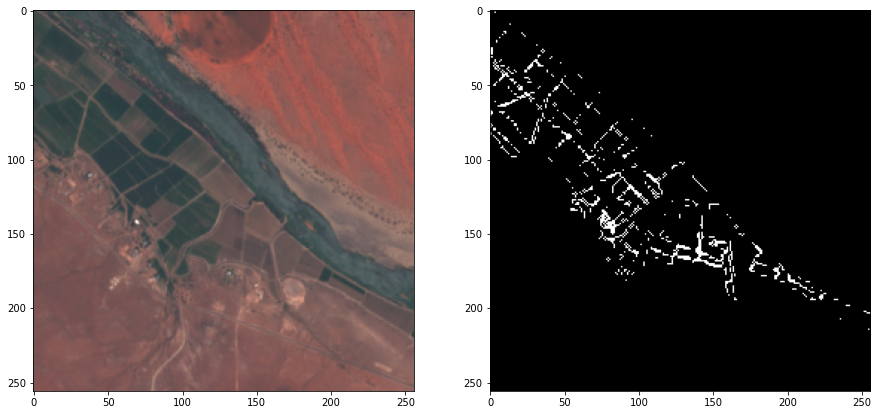

In [ ]:
# read and plot tile
mask_num =100

raster_image = cv2.imread(used_image_names[mask_num])
mask_image = cv2.imread(used_masks[mask_num], cv2.IMREAD_GRAYSCALE)


f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(raster_image)
axarr[1].imshow(mask_image, 'gray')